# Demonstration

In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('qDNA-default')

In [2]:
# -------------
# C13 positions
# -------------
# C13_pos = (8.713976612205478e-10, 0.0, 1.901805289026213e-10) # Suter
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
# C13_pos = (8.73e-10, 0.0, 1.86e-10) # rounded coordinates yield the same fidelities
# C13_pos = (4.722331100730915e-10, 0.0, 1.030637866442101e-10) # Dennis 

# -----------------------
# target gates and states
# -----------------------

init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )

# CNOT
cnot_gate = get_cnot_gate(2, 0, 1)
cnot_state = cnot_gate * init_state * cnot_gate.dag()

# Hadamard
hada_gate = get_hada_gate(2, 1)
hada_state = hada_gate * init_state * hada_gate.dag()

# Bell (Hadamard and CNOT)
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

# ---------------
# Pulse Sequences
# ---------------

# Suter Hadamard gate
# pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2]

# Suter CNOT gate
# pulse_seq = [3.78e-6, 2.11e-6, 2.15e-6, 0.63e-6, 1.88e-6, 3.96e-6, 1.9e-6, 0, np.pi/5, np.pi/2] 

# Dominik Bell state (without DD)
# pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]

# Dominik Bell state (with DD)
# pulse_seq = [0, 3.93e-6, 2.95e-6, 2.28e-6, 0.30e-6, -1.06, 4.68, 2.07, 0, -0.53, 6.26, -1.76, 0]

In [3]:
# parameters
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]
bath_configs = list( load_spin_baths('Dominik_C13', DATA_DIR).values() )[:10]

kwargs = dict(suter_method=True, instant_pulses=True, verbose=False,
             old_state=bell_state, target=bell_state, env_approx_level='no_bath')

## Simple Pulse Sequences

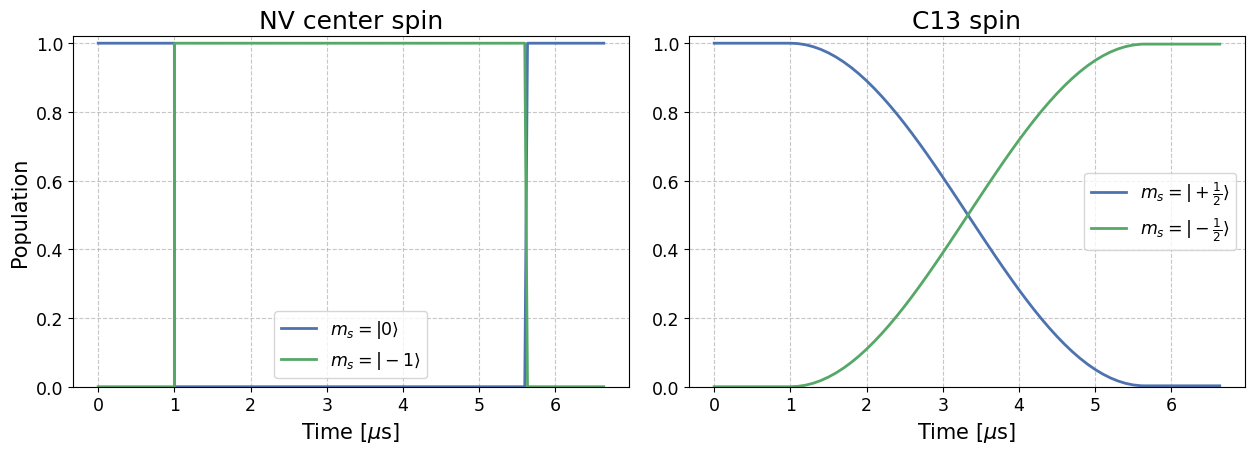

In [4]:
# pulse sequence to flip the C13 spin

env = Environment(register_config, bath_configs, **kwargs)
env.old_state = env.register_init_state

delta = env.matrices[0][2,3]
eps = env.matrices[0][3,3] - env.matrices[0][2,2]
T = np.pi/(2*np.pi*np.sqrt((delta**2 + eps**2)) )
env.pulse_seq = [1e-6, T/2, 1e-6, np.pi, np.pi, 0, 0]

t_list = env.get_t_list(stepsize=0.1e-6)
    
new_states_full = env.calc_new_states_full(t_list)
new_states = new_states_full[0]
fig, ax = plot_pops(t_list, new_states)

## Two Spin System

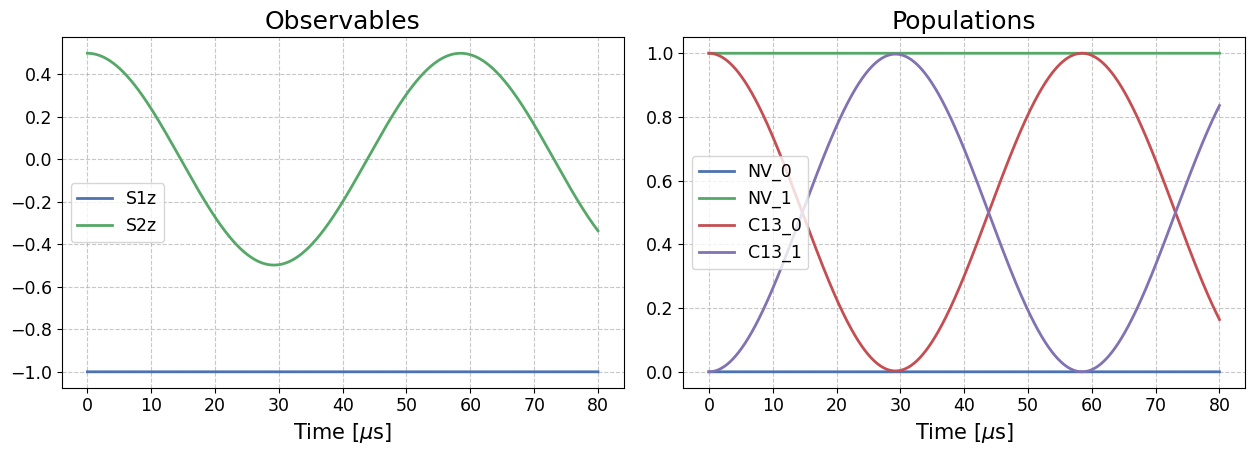

In [7]:
time = 80e-6
config_spin1 = ('NV', (0,0,0), 1, {})
config_spin2 = ('C13', C13_pos, 0, {})
two_spin_system = TwoSpinSystem(config_spin1, config_spin2, time, suter_method=kwargs['suter_method'])

fig, ax = plt.subplots(1, 2, figsize = (6.4*2, 4.8))
ax[0] = two_spin_system.plot_observables(ax[0], ['S1z', 'S2z'])
ax[1] = two_spin_system.plot_pops(ax[1])
plt.show()

## Random Spin Baths

In [10]:
# Create, save and load random spin baths

# spin_baths = save_spin_baths('C13_bath_configs', DATA_DIR, 'C13', 0.02e-2, 2e-9, 4.2e-9, 10, 10)
bath_configs = list(load_spin_baths('C13_bath_configs', DATA_DIR).values())

In [11]:
# Fig. 3 in Dominik's paper (binomial distribution)

rmin, rmax = 0, 1.8e-9
volume = 4/3 * np.pi * (rmax**3 - rmin**3)

a_C = CONST['a_C'] # lattice constant for carbon
V_unit = a_C**3 # volume of the unit cell
N_unit = CONST['N_unit'] # number of carbon atoms per unit cell
n = N_unit/V_unit # density of carbon atoms
N =  int(volume * n) # number of carbon atoms

# Binomial distribution: abundancy is probability of finding a C-13 instead of a C-12
abundancies = np.arange(2, 11) * 0.005e-2
more_than_zero, more_than_one, more_than_two = [], [], []
for abundancy in abundancies: 
    zero_C13 = (1-abundancy)**N
    one_C13 = N * abundancy * (1-abundancy)**(N-1)
    two_C13 = N*(N-1)/2 * abundancy**2 * (1-abundancy)**(N-2)
    more_than_zero.append( 1- zero_C13 )
    more_than_one.append( 1- zero_C13 - one_C13 )
    more_than_two.append( 1- zero_C13 - one_C13 - two_C13 )

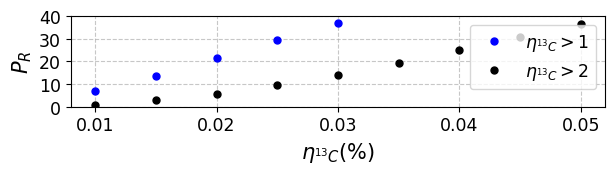

In [12]:
fig, ax = plt.subplots(figsize=(6.4, 4.8//2))

ax.plot(abundancies, more_than_one, 'b.', markersize=10, label=r'$\eta_{^{13}C}>1$')
ax.plot(abundancies, more_than_two, 'k.', markersize=10, label=r'$\eta_{^{13}C}>2$')

# plot settings
ax.set_ylabel(r'$P_R$')
ax.set_xlabel(r'$\eta_{^{13}C} (\%)$')
ax.set_ylim(0, 0.4)
# ax.set_xlim(0.01e-2, 0.05e-2)
ax.legend()
ax.set_xticks([0.01e-2, 0.02e-2, 0.03e-2, 0.04e-2, 0.05e-2], [0.01, 0.02, 0.03, 0.04, 0.05])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4], [0, 10, 20, 30, 40])

plt.show()